In [39]:
# Data processing 
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Dataset
from sklearn import datasets

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Modeling
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

In [2]:
# Load data
data = pd.read_csv('Nutritions_US.csv', encoding='latin-1')

In [4]:
data.head(5)

,NDB_No,Shrt_Desc,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),...,Vit_D_IU,Vit_K_(¾g),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,GmWt_Desc1,GmWt_2,GmWt_Desc2
0,1001,"BUTTER,WITH SALT",15.87,717,0.85,81.11,2.11,0.06,0.0,0.06,...,0.0,7.0,51.368,21.021,3.043,215.0,5.00,"1 pat, (1"" sq, 1/3"" high)",14.2,1 tbsp
1,1002,"BUTTER,WHIPPED,W/ SALT",16.72,718,0.49,78.30,1.62,2.87,0.0,0.06,...,0.0,4.6,45.390,19.874,3.331,225.0,3.80,"1 pat, (1"" sq, 1/3"" high)",9.4,1 tbsp
2,1003,"BUTTER OIL,ANHYDROUS",0.24,876,0.28,99.48,0.00,0.00,0.0,0.00,...,0.0,8.6,61.924,28.732,3.694,256.0,12.80,1 tbsp,205.0,1 cup
3,1004,"CHEESE,BLUE",42.41,353,21.40,28.74,5.11,2.34,0.0,0.50,...,21.0,2.4,18.669,7.778,0.800,75.0,28.35,1 oz,17.0,1 cubic inch
4,1005,"CHEESE,BRICK",41.11,371,23.24,29.68,3.18,2.79,0.0,0.51,...,22.0,2.5,18.764,8.598,0.784,94.0,132.00,"1 cup, diced",113.0,"1 cup, shredded"


In [15]:
data.shape

(8790, 52)

In [5]:
# Group columns by data type
grouped = data.columns.to_series().groupby(data.dtypes).groups

for dtype, columns in grouped.items():
    print(f"Columns with data type {dtype}: {', '.join(columns)}")

Columns with data type int64: NDB_No, Energ_Kcal
Columns with data type float64: Water_(g), Protein_(g), Lipid_Tot_(g), Ash_(g), Carbohydrt_(g), Fiber_TD_(g), Sugar_Tot_(g), Calcium_(mg), Iron_(mg), Magnesium_(mg), Phosphorus_(mg), Potassium_(mg), Sodium_(mg), Zinc_(mg), Copper_mg), Manganese_(mg), Selenium_(¾g), Vit_C_(mg), Thiamin_(mg), Riboflavin_(mg), Niacin_(mg), Panto_Acid_mg), Vit_B6_(mg), Folate_Tot_(¾g), Folic_Acid_(¾g), Food_Folate_(¾g), Folate_DFE_(¾g), Choline_Tot_ (mg), Vit_B12_(¾g), Vit_A_IU, Vit_A_RAE, Retinol_(¾g), Alpha_Carot_(¾g), Beta_Carot_(¾g), Beta_Crypt_(¾g), Lycopene_(¾g), Lut+Zea_ (¾g), Vit_E_(mg), Vit_D_¾g, Vit_D_IU, Vit_K_(¾g), FA_Sat_(g), FA_Mono_(g), FA_Poly_(g), Cholestrl_(mg), GmWt_1, GmWt_2
Columns with data type object: Shrt_Desc, GmWt_Desc1, GmWt_Desc2


In [16]:
# Drop the NDB_No, and GmWt_Desc1 and GmWt_Desc2 columns since they aren't needed 
df=data.drop(['NDB_No', 'GmWt_Desc1', 'GmWt_Desc2'], axis=1)

## Exploratory Data Analysis

### Missing Values



In [19]:
# Columns with a null value
columns_with_nan = df.columns[df.isna().any()]
df[columns_with_nan].isna().sum() 

Water_(g)               1
Ash_(g)               325
Fiber_TD_(g)          594
Sugar_Tot_(g)        1832
Calcium_(mg)          348
Iron_(mg)             144
Magnesium_(mg)        739
Phosphorus_(mg)       579
Potassium_(mg)        426
Sodium_(mg)            83
Zinc_(mg)             706
Copper_mg)           1257
Manganese_(mg)       2160
Selenium_(¾g)        1700
Vit_C_(mg)            818
Thiamin_(mg)          634
Riboflavin_(mg)       616
Niacin_(mg)           637
Panto_Acid_mg)       2242
Vit_B6_(mg)           905
Folate_Tot_(¾g)      1261
Folic_Acid_(¾g)      2039
Food_Folate_(¾g)     1768
Folate_DFE_(¾g)      2057
Choline_Tot_ (mg)    4016
Vit_B12_(¾g)         1193
Vit_A_IU              711
Vit_A_RAE            1535
Retinol_(¾g)         1806
Alpha_Carot_(¾g)     3258
Beta_Carot_(¾g)      3162
Beta_Crypt_(¾g)      3270
Lycopene_(¾g)        3292
Lut+Zea_ (¾g)        3315
Vit_E_(mg)           2889
Vit_D_¾g             3262
Vit_D_IU             3211
Vit_K_(¾g)           3563
FA_Sat_(g)  

In [34]:
print('Out of the {} columns, {} have empty or null values'.format(df.shape[1], len(df[columns_with_nan].isna().sum())) )

Out of the 49 columns, 44 have empty or null values


Normally, the number of columns and the amount of nans in the columns would be very concerning. Since this data involves nutritional content of a variety of foods, it is reasonable to assume the nans are due to the low or lack of presence of the amounts of the various nutritions and can be replaced with 0 values. 

In [37]:
df.fillna(0, inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Shrt_Desc          8790 non-null   object 
 1   Water_(g)          8790 non-null   float64
 2   Energ_Kcal         8790 non-null   int64  
 3   Protein_(g)        8790 non-null   float64
 4   Lipid_Tot_(g)      8790 non-null   float64
 5   Ash_(g)            8790 non-null   float64
 6   Carbohydrt_(g)     8790 non-null   float64
 7   Fiber_TD_(g)       8790 non-null   float64
 8   Sugar_Tot_(g)      8790 non-null   float64
 9   Calcium_(mg)       8790 non-null   float64
 10  Iron_(mg)          8790 non-null   float64
 11  Magnesium_(mg)     8790 non-null   float64
 12  Phosphorus_(mg)    8790 non-null   float64
 13  Potassium_(mg)     8790 non-null   float64
 14  Sodium_(mg)        8790 non-null   float64
 15  Zinc_(mg)          8790 non-null   float64
 16  Copper_mg)         8790 

Lets look at the numerical summary of the columns/features

In [38]:
df.iloc[:, 1:].describe()

,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),...,Vit_E_(mg),Vit_D_¾g,Vit_D_IU,Vit_K_(¾g),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,GmWt_2
count,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,...,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000
mean,54.106061,226.317634,11.342849,10.553725,1.717527,22.127710,2.039625,6.762531,73.700114,2.655447,...,0.893890,0.364300,14.591809,9.295370,3.434338,3.771797,2.115612,38.718885,93.105193,137.640216
std,30.776516,169.877539,10.530474,15.814842,2.967679,27.270822,4.267904,13.723474,200.017998,5.651177,...,3.853351,3.091688,123.670680,62.125274,6.426162,6.825884,5.050857,117.353035,84.713057,309.447941
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.692500,91.000000,2.380000,0.950000,0.770000,0.050000,0.000000,0.000000,8.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.149000,0.074250,0.134250,0.000000,28.350000,0.000000
50%,63.080000,191.000000,8.000000,5.140000,1.170000,9.340000,0.400000,0.490000,19.000000,1.325000,...,0.120000,0.000000,0.000000,0.000000,1.435500,1.600000,0.591500,2.000000,85.000000,15.000000
75%,77.960000,337.000000,19.880000,13.720000,2.020000,34.910000,2.400000,6.057500,64.000000,2.570000,...,0.470000,0.000000,1.000000,1.900000,4.173750,4.759000,1.880000,65.000000,128.000000,186.000000
max,100.000000,902.000000,88.320000,100.000000,99.800000,100.000000,79.000000,99.800000,7364.000000,123.600000,...,149.400000,250.000000,10000.000000,1714.500000,95.600000,83.689000,74.623000,3100.000000,1184.000000,5717.000000


Let's look at the correlations between the float columns.

In [40]:
float_columns = [x for x in df.columns if x not in ['Shrt_Desc', 'Energ_Kcal']]

# The correlation matrix
corr_mat = df[float_columns].corr()

# Strip out the diagonal values for the next step
for x in range(len(float_columns)):
    corr_mat.iloc[x,x] = 0.0
    
corr_mat

,Water_(g),Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),Magnesium_(mg),...,Vit_E_(mg),Vit_D_¾g,Vit_D_IU,Vit_K_(¾g),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,GmWt_2
Water_(g),0.000000,-0.103833,-0.489584,-0.235744,-0.774010,-0.385601,-0.457883,-0.237414,-0.349057,-0.391178,...,-0.231762,-0.057984,-0.057947,0.020771,-0.367960,-0.390598,-0.399317,0.055348,0.396132,0.147064
Protein_(g),-0.103833,0.000000,0.062336,0.106315,-0.304295,-0.074143,-0.269321,0.046245,0.128590,0.217982,...,-0.028482,0.018185,0.018243,-0.071973,0.052530,0.094276,-0.039389,0.290245,-0.149047,0.193043
Lipid_Tot_(g),-0.489584,0.062336,0.000000,-0.005906,-0.048594,-0.023089,-0.000276,0.016833,-0.035627,0.082351,...,0.337699,0.073140,0.073059,0.015055,0.764603,0.868514,0.703962,0.087229,-0.256681,0.003930
Ash_(g),-0.235744,0.106315,-0.005906,0.000000,0.119708,0.179003,0.006669,0.474304,0.197636,0.258841,...,0.054890,0.022577,0.022641,0.062480,-0.023510,-0.001901,0.016658,-0.006389,-0.130826,-0.049805
Carbohydrt_(g),-0.774010,-0.304295,-0.048594,0.119708,0.000000,0.455710,0.617259,0.189064,0.344312,0.283977,...,0.072081,0.014612,0.014592,-0.011403,-0.043835,-0.096127,0.054849,-0.219735,-0.220803,-0.232494
Fiber_TD_(g),-0.385601,-0.074143,-0.023089,0.179003,0.455710,0.000000,0.107561,0.233700,0.380423,0.540110,...,0.153374,-0.011303,-0.011272,0.155161,-0.075663,-0.030789,0.073603,-0.145824,-0.076920,-0.148700
Sugar_Tot_(g),-0.457883,-0.269321,-0.000276,0.006669,0.617259,0.107561,0.000000,0.125703,0.113846,0.041107,...,0.066531,0.054585,0.054501,-0.014826,0.068650,-0.063346,-0.005232,-0.136263,-0.148557,-0.139017
Calcium_(mg),-0.237414,0.046245,0.016833,0.474304,0.189064,0.233700,0.125703,0.000000,0.351912,0.310152,...,0.116558,0.067348,0.067380,0.171640,0.034857,-0.008598,0.010034,-0.037233,-0.108749,-0.081314
Iron_(mg),-0.349057,0.128590,-0.035627,0.197636,0.344312,0.380423,0.113846,0.351912,0.000000,0.399424,...,0.166128,0.080535,0.080755,0.175387,-0.052289,-0.035025,0.002011,0.005995,-0.187737,-0.085940
Magnesium_(mg),-0.391178,0.217982,0.082351,0.258841,0.283977,0.540110,0.041107,0.310152,0.399424,0.000000,...,0.198854,0.017619,0.017615,0.157430,-0.017668,0.091514,0.148403,-0.061532,-0.112915,-0.089560


<Axes: >

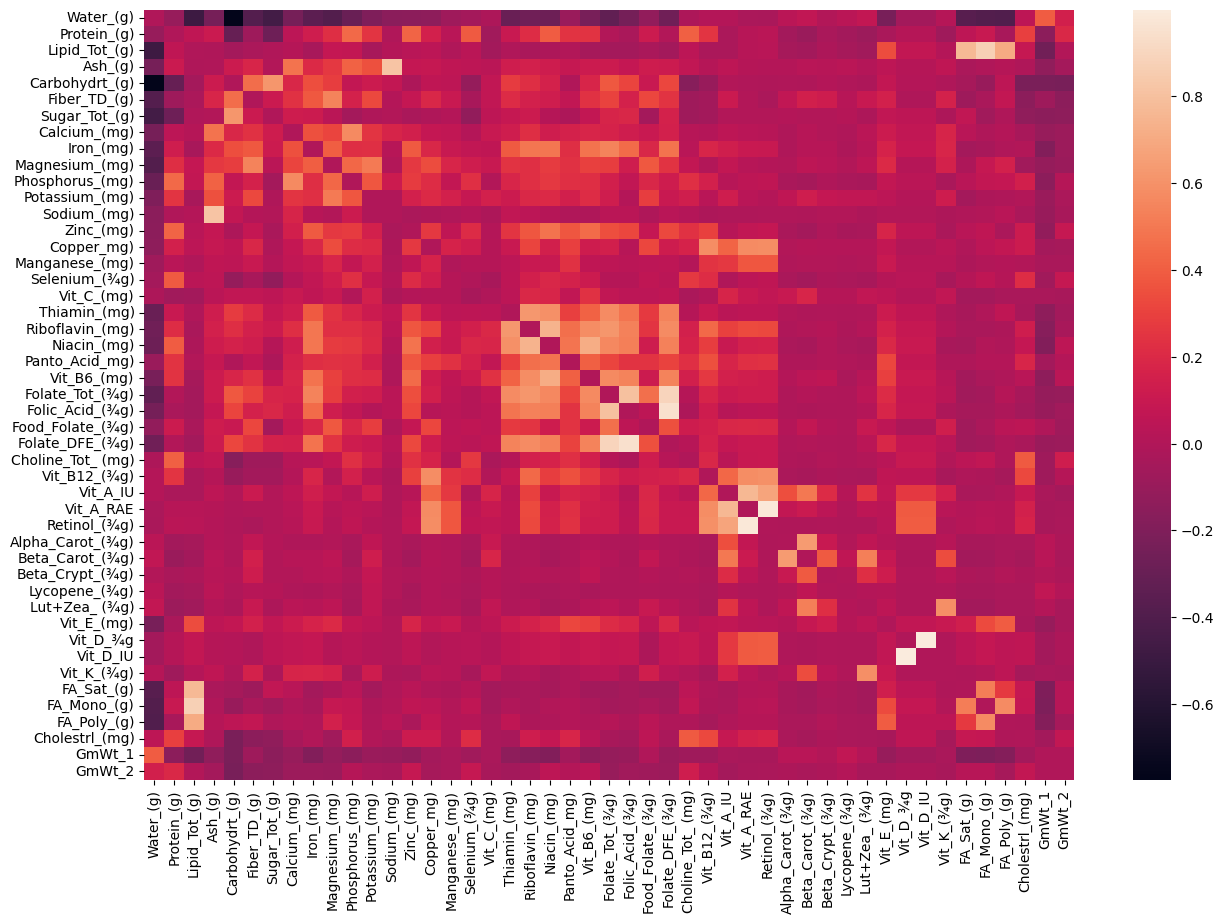

In [43]:
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(corr_mat)

We don't see many highly correlated features with the exceptions of a few pairings ( Vit_D_3/4g and Vid_D_IU, Retional and Vit_A, Folate_DFE and Folate_Acid). 

Now lets look at the skewness of the attributes.

In [45]:
skew_columns = (df[float_columns]
                .skew()
                .sort_values(ascending=False))

skew_columns = skew_columns.loc[skew_columns > 0.75]
print("{} of the 47 columns are skewed with the vast majority being heavily skewed".format(len(skew_columns)))
skew_columns

46 of the 47 columns are skewed with the vast majority being heavily skewed


Vit_D_¾g             61.111488
Vit_D_IU             61.105802
Manganese_(mg)       40.433711
Beta_Crypt_(¾g)      38.667063
Selenium_(¾g)        38.441668
Vit_C_(mg)           29.549434
Alpha_Carot_(¾g)     29.098417
Retinol_(¾g)         25.313237
Vit_A_RAE            24.355932
Lycopene_(¾g)        24.246488
Sodium_(mg)          22.513287
Beta_Carot_(¾g)      19.196363
Phosphorus_(mg)      18.530683
Thiamin_(mg)         18.149933
Ash_(g)              17.017930
Copper_mg)           16.362549
Vit_K_(¾g)           16.293227
Choline_Tot_ (mg)    15.672419
Potassium_(mg)       15.590756
Vit_A_IU             15.456607
Cholestrl_(mg)       15.322793
Panto_Acid_mg)       14.853265
Vit_E_(mg)           13.700820
Calcium_(mg)         13.432410
Lut+Zea_ (¾g)        13.356796
Vit_B12_(¾g)         13.212239
Food_Folate_(¾g)     13.045058
Riboflavin_(mg)      11.772537
Folic_Acid_(¾g)      10.927219
Folate_DFE_(¾g)      10.546925
Zinc_(mg)             9.593906
Folate_Tot_(¾g)       8.944269
Vit_B6_(

Since the attributes are skewed and possess different scales, I'll do a log transform and peform feature scaling to prepare the data for the models.

In [46]:
# Perform log transform on skewed columns
for col in skew_columns.index.tolist():
    df[col] = np.log1p(df[col])

In [51]:
df.drop('Energ_Kcal', axis=1, inplace=True)

In [52]:
sc = StandardScaler()
df[float_columns] = sc.fit_transform(df[float_columns])

df.describe()

,Water_(g),Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),Magnesium_(mg),...,Vit_E_(mg),Vit_D_¾g,Vit_D_IU,Vit_K_(¾g),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,GmWt_2
count,8.790000e+03,8.790000e+03,8.790000e+03,8.790000e+03,8.790000e+03,8.790000e+03,8.790000e+03,8.790000e+03,8.790000e+03,8.790000e+03,...,8.790000e+03,8.790000e+03,8.790000e+03,8.790000e+03,8.790000e+03,8.790000e+03,8.790000e+03,8.790000e+03,8.790000e+03,8.790000e+03
mean,-6.871005e-18,1.293366e-17,7.477270e-18,-1.293366e-17,-4.850121e-18,-2.101719e-17,2.101719e-17,1.616707e-18,4.850121e-18,-1.616707e-18,...,6.466828e-18,-1.616707e-18,-1.616707e-18,-9.700242e-18,-1.293366e-17,-6.466828e-18,-1.616707e-18,1.746044e-16,1.293366e-17,-2.586731e-17
std,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,...,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00
min,-1.758131e+00,-1.915338e+00,-1.495841e+00,-1.695331e+00,-1.323316e+00,-8.355773e-01,-8.200624e-01,-2.071709e+00,-1.307576e+00,-2.120033e+00,...,-5.785349e-01,-3.400762e-01,-5.061267e-01,-6.266014e-01,-1.135562e+00,-1.107065e+00,-9.396471e-01,-9.547157e-01,-3.333763e+00,-1.017361e+00
25%,-7.932981e-01,-7.759399e-01,-9.317373e-01,-5.437054e-01,-1.293105e+00,-8.355773e-01,-8.200624e-01,-6.276376e-01,-7.378398e-01,-2.916715e-01,...,-5.785349e-01,-3.400762e-01,-5.061267e-01,-6.266014e-01,-9.803793e-01,-1.031195e+00,-7.735848e-01,-9.547157e-01,-5.517354e-01,-1.017361e+00
50%,2.916006e-01,1.403020e-01,3.710858e-02,-1.327610e-01,1.231212e-01,-4.237345e-01,-5.098541e-01,-1.028383e-01,-1.220323e-01,2.013725e-01,...,-3.754099e-01,-3.400762e-01,-5.061267e-01,-6.266014e-01,-1.410018e-01,-9.488839e-02,-3.270855e-01,-4.147510e-01,3.333112e-01,5.522485e-02
75%,7.751136e-01,9.276405e-01,7.756852e-01,5.338939e-01,8.940084e-01,6.623267e-01,7.000267e-01,6.718032e-01,4.805602e-01,4.733321e-01,...,1.119916e-01,-3.400762e-01,-1.975960e-02,2.704733e-01,7.008177e-01,7.475251e-01,4.547878e-01,1.104487e+00,6.671133e-01,1.006312e+00
max,1.491285e+00,2.287418e+00,2.402471e+00,7.609042e+00,1.534314e+00,4.528034e+00,2.768503e+00,3.780548e+00,5.472390e+00,2.959537e+00,...,8.407069e+00,1.333279e+01,5.956649e+00,5.648275e+00,3.971113e+00,3.595168e+00,4.762798e+00,2.996665e+00,2.492839e+00,2.329453e+00
